In [34]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os

In [35]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [36]:
# Initialize CartPole environment
#env_name = 'CartPole-v1'
#env_name = 'MountainCarContinuous-v0'
#env_name = 'MountainCar-v0'
env_name = 'Pendulum-v1'

# Create the CartPole environment
env = gym.make(env_name)

# Define the Monte Carlo Dropout model

In [37]:
class MC_Dropout_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_network):
        super(MC_Dropout_Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        self.num_network = num_network
        
        # Define the layers
        self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(nn.Dropout(p=dropout_prob))
        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)

    def forward(self, x):
        total_output = 0.0
        for i in range(self.num_network):
            x_temp = x
            x_temp = self.activation(self.input_layer(x_temp))
            for hidden_layer in self.hidden_layers:
                x_temp = self.activation(hidden_layer(x_temp))
            output = self.output_layer(x_temp)
            total_output += output
        average_output = total_output / self.num_network
        return average_output


# Initialize the model

In [38]:
#Initialize parameters for model
action = env.action_space.sample()

if isinstance(action, int):
    input_size = env.observation_space.shape[0] + 1
elif isinstance(action, np.ndarray):
    input_size = env.observation_space.shape[0] + len(action)

output_size = env.observation_space.shape[0] + 2
num_hidden_layers = 3
hidden_layer_nodes = 20
activation = F.relu
learning_rate = 0.01
dropout_prob = 0.3
num_networks = 5


# Instantiate the model
model = MC_Dropout_Net(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_networks).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loading the Dataset

In [39]:
batch_size = 32

num_samples = '50k'

# Load datasets
with open(env_name + '_' + num_samples + '_train_dataset.pkl', 'rb') as f:
    train_dataset_loaded = pickle.load(f)

with open(env_name + '_' + num_samples + '_test_dataset.pkl', 'rb') as f:
    test_dataset_loaded = pickle.load(f)

train_loader = torch.utils.data.DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle=False)

# Training the Model 

In [40]:
model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'.pth' 

'''
if os.path.exists(model_weights_file_path):
    model.load_state_dict(torch.load('model_weights.pth'))
'''

# Training loop with evaluation
num_epochs = 50
train_losses = []
test_losses = []
save_interval = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss)
    
    # Evaluation on test data
    #model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()
    epoch_test_loss = running_test_loss / len(test_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss}")
    
    if (epoch + 1) % save_interval == 0:
        # Save model state
        torch.save(model.state_dict(), f'montecarlodropout_{env_name}_{num_samples}_epoch_{epoch+1}.pt')
        
    test_losses.append(epoch_test_loss)

Epoch [1/50], Training Loss: 2.975367941761017
Epoch [1/50], Test Loss: 2.818069199784495
Epoch [2/50], Training Loss: 2.724068147277832
Epoch [2/50], Test Loss: 2.7414820803620943
Epoch [3/50], Training Loss: 2.6667794897079466
Epoch [3/50], Test Loss: 2.7135560634418034
Epoch [4/50], Training Loss: 2.642442583179474
Epoch [4/50], Test Loss: 2.6468222845857516
Epoch [5/50], Training Loss: 2.639388488483429
Epoch [5/50], Test Loss: 2.6673267161884247
Epoch [6/50], Training Loss: 2.6280567712783816
Epoch [6/50], Test Loss: 2.614171108498741
Epoch [7/50], Training Loss: 2.637756496143341
Epoch [7/50], Test Loss: 2.773378559575675
Epoch [8/50], Training Loss: 2.6349081681251527
Epoch [8/50], Test Loss: 2.6524836247721417
Epoch [9/50], Training Loss: 2.6166102779388427
Epoch [9/50], Test Loss: 2.716686177177551
Epoch [10/50], Training Loss: 2.6161154432296754
Epoch [10/50], Test Loss: 2.6300444762927655
Epoch [11/50], Training Loss: 2.6163379276275633
Epoch [11/50], Test Loss: 2.6550303880

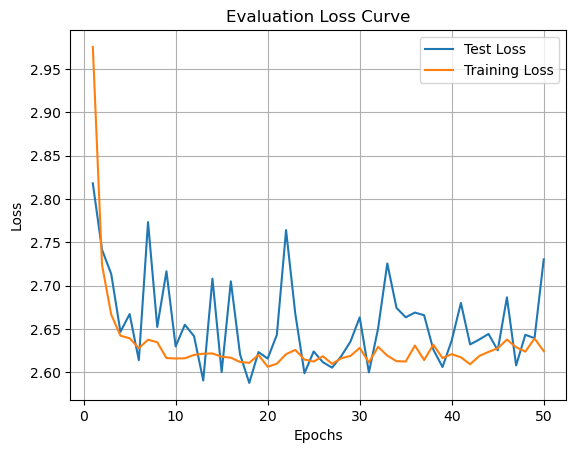

In [41]:
# Plotting the evaluation loss curve
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss Curve')
plt.legend()
plt.grid(True)
# Save the plot
plt.savefig('montecarlodropout_'+ env_name + '_' + num_samples + '_evaluation_loss_curve.png')
plt.show()

In [42]:
# Switch model to evaluation mode
#model.eval()

# Lists to store predictions and true labels
predictions = []
true_labels = []

# Iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(true_labels, predictions)
r2 = r2_score(true_labels, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 2.7207534313201904
R-squared: 0.2410692337671359


In [43]:
model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'.pth' 
# Save the trained model
torch.save(model.state_dict(), model_weights_file_path)

In [44]:
model = MC_Dropout_Net(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_networks).to(device)

model.load_state_dict(torch.load(model_weights_file_path))

<All keys matched successfully>

# Genearate MDP

In [29]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
!pip install tensorflow
!pip install pandas
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import os
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [30]:
env_name = 'CartPole-v1'

num_samples = '10k'

model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'.pth' 

model = MC_Dropout_Net(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_networks).to(device)

model.load_state_dict(torch.load(model_weights_file_path))

RuntimeError: Error(s) in loading state_dict for MC_Dropout_Net:
	size mismatch for input_layer.weight: copying a param with shape torch.Size([20, 5]) from checkpoint, the shape in current model is torch.Size([20, 4]).
	size mismatch for output_layer.weight: copying a param with shape torch.Size([6, 20]) from checkpoint, the shape in current model is torch.Size([5, 20]).
	size mismatch for output_layer.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([5]).

In [ ]:
class Sample:
    def __init__(self, model, env):
        self.model = model
        # Create the CartPole environment
        self.env = env
        self.df_discrete = None
        self.df_MDP = None
        
    def generateSample(self, filename, episodes=1000, max_episode_length=2000, noise = 0):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        state_size = self.env.observation_space.shape[0]
        #state_size = 4
        samples = []
        for episode in range(episodes):
            state = self.env.reset()[0]
            episode_length = 0

            while episode_length <= max_episode_length:
                action = self.env.action_space.sample()
                input_model = list(state) + [action]
                input_model = torch.tensor(input_model, device=device, dtype=torch.float32)
                #print(f"Model is on device: " + str(next(model.parameters()).device))
                #print(f"input_model is on device: {input_model.device}")
                next_state = self.model(input_model)
                state = list(state)
                action = [str(action)]
                next_state = next_state.tolist()
                next_state, reward, done = next_state[:-2], next_state[-2], next_state[-1]
                reward = [reward]
                #next_state = [noise*random.uniform(-1, 1)+next_state[i] for i in range(state_size)]
                #next_state = self.add_noise(next_state)

                sample = state + action + reward + next_state
                samples.append(sample)
                state = next_state
                
                episode_length += 1
                if done:
                    break
                    
        df = pd.DataFrame(samples)
        df.columns = [f'variable_{i}' for i in range(state_size)] + ['action','reward'] + [f'nx_variable_{i}' for i in range(state_size)]
        self.df_data = df
        df.to_csv(filename, index=False)  

In [ ]:
# Create the CartPole environment
env = gym.make(env_name)
sample = Sample(model,env)
sample_filename = 'monte_carlo_dropout_'+ env_name + '_' + num_samples + '_sample.csv'
sample.generateSample(max_episode_length = 100, noise = 0, filename = sample_filename)